In [4]:
import os 

os.chdir('C:/Users/rfuchs/Documents/GitHub/M1DGMM')

from copy import deepcopy

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder

import pandas as pd

from gower import gower_matrix
from sklearn.metrics import silhouette_score


from MIAMI import miami
from init_params import dim_reduce_init
from metrics import misc
from data_preprocessing import gen_categ_as_bin_dataset, \
        compute_nj


import autograd.numpy as np
from autograd.numpy.random import uniform

In [5]:
###############################################################################
###############         Heart    vizualisation          #######################
###############################################################################

#===========================================#
# Importing data
#===========================================#
os.chdir('C:/Users/rfuchs/Documents/These/Stats/mixed_dgmm/datasets')

heart = pd.read_csv('heart_statlog/heart.csv', sep = ' ', header = None)
y = heart.iloc[:,:-1]
labels = heart.iloc[:,-1]
labels = np.where(labels == 1, 0, labels)
labels = np.where(labels == 2, 1, labels)

y = y.infer_objects()
numobs = len(y)

# Too many zeros for this "continuous variable". Add a little noise to avoid 
# the correlation matrix for each group to blow up
uniform_draws = uniform(0, 1E-12, numobs)
y.iloc[:, 9] = np.where(y[9] == 0, uniform_draws, y[9])

n_clusters = len(np.unique(labels))
p = y.shape[1]


In [6]:
#===========================================#
# Formating the data
#===========================================#
var_distrib = np.array(['continuous', 'bernoulli', 'categorical', 'continuous',\
                        'continuous', 'bernoulli', 'categorical', 'continuous',\
                        'bernoulli', 'continuous', 'ordinal', 'ordinal',\
                        'categorical']) 
    
# Ordinal data already encoded
 
y_categ_non_enc = deepcopy(y)
vd_categ_non_enc = deepcopy(var_distrib)

# Encode categorical datas
le = LabelEncoder()
for col_idx, colname in enumerate(y.columns):
    if var_distrib[col_idx] == 'categorical': 
        y[colname] = le.fit_transform(y[colname])

# Encode binary data
le = LabelEncoder()
for col_idx, colname in enumerate(y.columns):
    if var_distrib[col_idx] == 'bernoulli': 
        y[colname] = le.fit_transform(y[colname])
    
enc = OneHotEncoder(sparse = False, drop = 'first')
labels_oh = enc.fit_transform(np.array(labels).reshape(-1,1)).flatten()

nj, nj_bin, nj_ord, nj_categ = compute_nj(y, var_distrib)
y_np = y.values
nb_cont = np.sum(var_distrib == 'continuous')

p_new = y.shape[1]


# Feature category (cf)
cf_non_enc = np.logical_or(vd_categ_non_enc == 'categorical', vd_categ_non_enc == 'bernoulli')

# Non encoded version of the dataset:
y_nenc_typed = y_categ_non_enc.astype(np.object)
y_np_nenc = y_nenc_typed.values

# Defining distances over the non encoded features
dm = gower_matrix(y_nenc_typed, cat_features = cf_non_enc) 

dtype = {y.columns[j]: np.float64 if (var_distrib[j] != 'bernoulli') and \
        (var_distrib[j] != 'categorical') else np.str for j in range(p_new)}

y = y.astype(dtype, copy=True)

In [7]:
#===========================================#
# Defining hyperparameters
#===========================================# 

r = np.array([3, 1])
numobs = len(y)
k = [n_clusters]

seed = 1
init_seed = 2
    
eps = 1E-05
it = 50
maxstep = 100

0
[-3525.0585884508587]


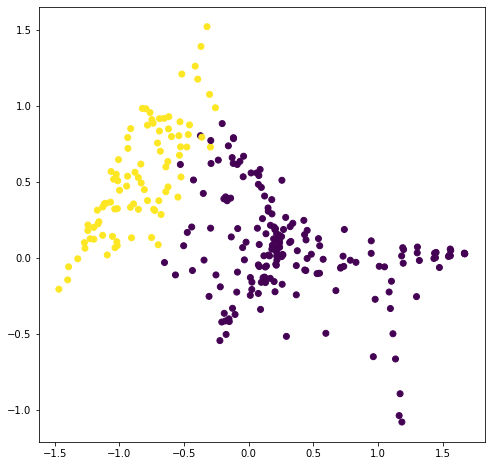

1
[-3525.0585884508587, -3483.4847055222244]


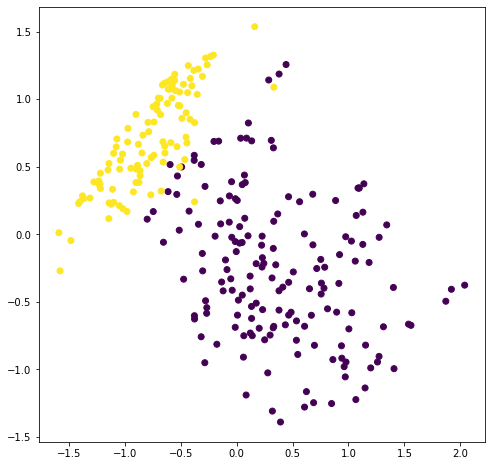

2
[-3525.0585884508587, -3483.4847055222244, -3456.646524215853]


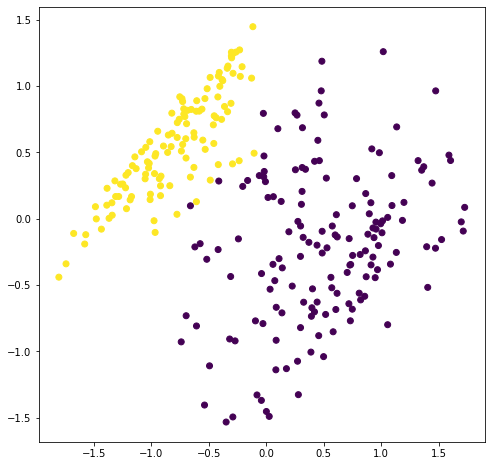

3
[-3525.0585884508587, -3483.4847055222244, -3456.646524215853, -3459.4338677547075]


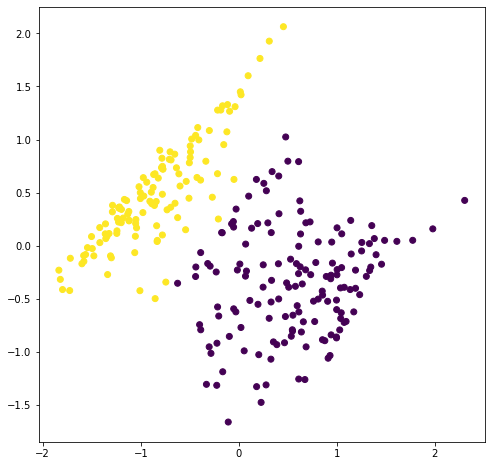

4
[-3525.0585884508587, -3483.4847055222244, -3456.646524215853, -3459.4338677547075, -3463.7900164234284]


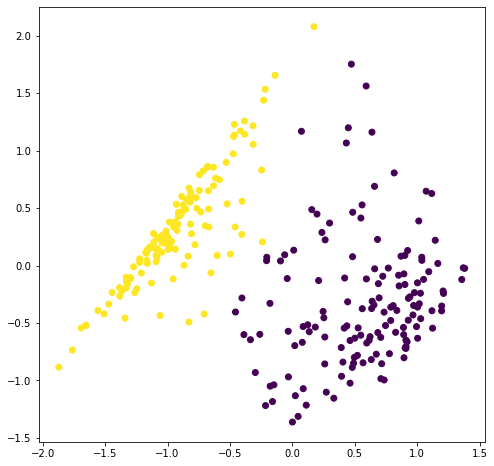

In [8]:
#===========================================#
# Running the algorithm
#===========================================# 

import matplotlib .pyplot as plt
prince_init = dim_reduce_init(y, n_clusters, k, r, nj, var_distrib, seed = None,\
                              use_famd=True)
out = miami(y_np, n_clusters, r, k, prince_init, var_distrib, nj, it,\
             eps, maxstep, seed, perform_selec = False)


# Plotting utilities
varnames = ['age', 'sex', 'chest pain type', 'resting blood pressure',\
            'serum cholesterol in mg/dl', 'fasting blood sugar > 120 mg/dl',\
            'resting electrocardiographic results', 'maximum heart rate achieved',\
            'exercise induced angina', 'ST depression induced by exercise relative to rest',\
            'the slope of the peak exercise ST segment',\
            'number of major vessels (0-3)', 'thal']

y_new = out['y'][len(y):]

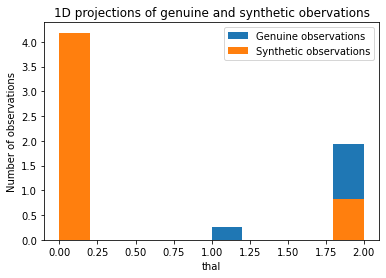

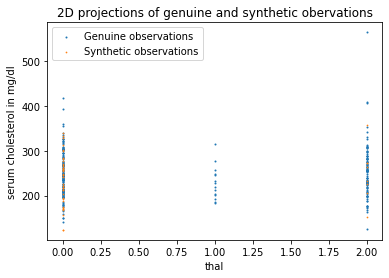

In [10]:
#===========================================#
# Visualisation of the resultts
#===========================================# 

# Choose the variables number
var1 = -1
var2 = 4


# Check for 1D distribution
plt.hist(y_np[:,var1], density = True)
plt.hist(y_new[:,var1], density = True)
plt.xlabel(varnames[var1])
plt.ylabel('Number of observations')
plt.legend(['Genuine observations', 'Synthetic observations'])
plt.title('1D projections of genuine and synthetic obervations')
plt.show()


# Check for 2D distribution
plt.scatter(y_np[:,var1], y_np[:,var2],  label = 'Genuine observations', s = 1)
plt.scatter(y_new[:,var1], y_new[:,var2], label = 'Synthetic observations', s = 0.5)
plt.xlabel(varnames[var1])
plt.ylabel(varnames[var2])
plt.legend(['Genuine observations', 'Synthetic observations'])
plt.title('2D projections of genuine and synthetic obervations')
plt.show()
